In [1]:
#Import libraries

import numpy as np
import pandas as pd

import pickle
import re
import glob
import os
import sys
%pylab inline
%matplotlib inline
#Set some List
myAA = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"]
FullAmino = ["ARG","HIS","LYS","ASP","GLU","SER","THR","ASN","GLN","CYS","GLY","PRO","ALA","VAL","ILE","LEU","MET","PHE","TYR","TRP"]


Populating the interactive namespace from numpy and matplotlib


In [2]:
#Function that read PDB file and store every atoms in an array
#Each array entries is a dict
#Mask allow you to keep only certain type of atoms

def read_pdb_seq(myF,keep_hydrogen = 1,keep_het = 1,mask=""):
    lines = [line.rstrip('\n') for line in open(myF)]
    Nresnumc = "NA"
    myPDB = []
    myC = 0
    for l in lines:
     # print(l)
        # My hash
        raw = {}
        if (re.search(' H\s*$',l) != None and keep_hydrogen == 0):
            continue
        if (re.search('^HET',l) != None and keep_het == 0):
            continue
        if mask != "":
            pattern = re.compile(mask)
            if not pattern.search(l):
                continue
        m = re.search('^ATOM........(....).(...) (.)\s*(\d+)\s*(-*\d+\.\d{3})\s*(-*\d+.\d{3})\s*(-*\d+.\d{3})', l)
        if (m == None):
            print('Can t find patern in '+l)
            continue
        # Get resnumc
        resnumc = str(m.group(2)) + " " + str(m.group(4)) + " " + str(m.group(3))
     # print(m.group(4,5,6))
        myCord = m.group(5,6,7)
        nCord = [float(i) for i in myCord]
        raw['coord'] = nCord
        raw['res'] = m.group(2)
        raw['num'] = m.group(4)
        raw['cha'] = m.group(3)
        raw['atom'] = m.group(1)
        raw['resnumc'] = resnumc
        raw['ID'] = myC
        myC += 1
        myPDB.append(raw)
     # break
    return(myPDB)

In [3]:
#Function that read the etabx file
#THis file is a log file from dTERMen and we can get stat and invidual score

def get_etabx_stat(etabx):
    #Open File
    lines = [line.rstrip('\n') for line in open(etabx)]
    
    #Stat for count
    TermSTAT = dict()
    
    #Some Scoring
    TermScor = dict()
    
    for l in lines:
        #Skip small line
        if len(l) < 40:
            continue
            
        #Find what peppos it is
        m = re.search("^[A-Za-z0-9_]+\((.),(\d+), (\S+), (.)",l)
        if m == None:
            print(l)
            continue
        ch = m.group(1)
        num = m.group(2)
        res = m.group(4)
        
        #RES,NUM,C
        kr = ",".join([res,num,ch])
        #NUM,C
        numc = ",".join([num,ch])
        
        #Init some dict
        if kr not in TermScor:
            TermScor[kr] = dict()
        #Init some dict
        if numc not in TermSTAT:
            TermSTAT[numc] = dict()
        
        #This is some selfcorrectin score (I think)
        #Just get the score and next
        if "SelfCorr" in l:
            #Will next for now
            continue
            sp = re.split("\s+",l)
            TermScor[kr][kr] = TermScor[kr].get(kr,0.0)+float(sp[-1])
            continue
        
        
        #Load self score
        m = re.search("SelfScore\((.),(\d+),.*, .\).*\/(\d+)",l)
        if m != None:
            ener = re.split("\s+",l)[-1][:-1]
            TermScor[kr][kr] = TermScor[kr].get(kr,0.0)+float(ener)
            TermSTAT[numc][numc] = int(m.group(3))
            continue
            
        #Pair score
        if re.search("PairScore\(.*, .\) \(IMM",l):
            m = re.search("PairScore\(B,(\d+),.*\/(\d+)",l)
            sp = re.split("\(IMM",l)
            for spl in sp[1:]:
                m = re.search(" (\S,\d+).*(.)\).*\/(\d+).*\s+(\S+)\]",spl)
                ener = m.group(4)
                cou = m.group(3)
                ma = re.split("\s*,\s*",spl.split(")")[0][1:])
                recpos = ",".join([ma[3],ma[2],ma[0]])
                numct = ",".join(m.group(1).split(",")[::-1])
                
                
                TermSTAT[numc][numct] = int(cou)
                #Store Energy
                TermScor[kr][recpos] = float(ener)
                if recpos not in TermScor:
                    TermScor[recpos] = dict()
                TermScor[recpos][kr] = float(ener)
            continue
        m = re.search("PairScore\((.),(\d+), \d+, ., B,(\d+), \d+, (.)\).*/(\d+).*]\s+(\S+)",l)
        if m == None:
            continue
        tkr = ",".join([m.group(4),m.group(3),m.group(1)])
        numct = ",".join([m.group(3),m.group(1)])
        ener = float(m.group(6))
        cou = int(m.group(5))
        #Update term score
        TermScor[kr][tkr] = float(ener)
        if tkr not in TermScor:
            TermScor[tkr] = dict()
        TermScor[tkr][kr] = float(ener)
        #Update term stat
        TermSTAT[numc][numct] = float(cou)
        #if numct not in TermScor:
        #    TermSTAT[numct] = dict()
    
    #Fill the matrices
    for x in sorted(TermSTAT):
        for xt in sorted(TermSTAT[x].keys()):
            if xt not in TermSTAT:
                TermSTAT[xt] = dict()
            TermSTAT[xt][x] = TermSTAT[x][xt]
    for x in sorted(TermScor):
        for xt in sorted(TermScor[x].keys()):
            if xt not in TermScor:
                TermScor[xt] = dict()
            TermScor[xt][x] = TermScor[x][xt]
    return(TermSTAT,TermScor)

In [4]:
#Load Alignemnt
# (I have already aligned receptor sequence)
#Alignment is usufell to know sequence composition of Binding Site in other receptor
f = "./data/BenchRecep.aln"
lines = [line.rstrip('\n') for line in open(f)]
AllAli = dict()


for l in lines[3:-1]:
    sp = re.split("\s+",l)
    if len(sp[0]) < 2:continue
    if len(l) < 10:
        continue
    if len(sp) != 2:continue
    if sp[0] not in AllAli:
        AllAli[sp[0]] = []
    AllAli[sp[0]] += list(sp[1])




In [5]:

#This is all the etbax
PathToEtab = "/media/vince/Postdoc/dTERMn/scoring/"


alletab = sorted(glob.glob(PathToEtab+"./energy_table/*_HUMAN_*_holo_35.etabx"))
print(len(alletab))

69


In [6]:

#Here I'm loading all the scoring matrix
#I'm also normalizing the peptide-receptor interaction, so that they are constant across template (and receptor)

AllNormScore = dict()
BindingMode = dict()
CountContact = dict()
for etab in alletab:
    #Use only croped
    if "lp" in etab:continue
    if "5C3F" in etab:continue
    print(etab)
    pdbName = "_".join(etab.split("/")[-1].split("_")[:-1])
    pdb = read_pdb_seq("./query_pdb/"+pdbName+".pdb",keep_hydrogen = 0,keep_het = 0,mask="ATOM.* CA .*")
    
    #Loab scoring matrix
    (TermSTAT,TermScor) = get_etabx_stat(etab)
    #Check pep len
    PepK = []
    for k in TermSTAT.keys():
        if ",B" not in k:continue
        PepK.append(k)
    if len(PepK) != 20:continue
    
    #Transform recep k to universal number
    if pdbName not in AllAli:
        continue
    nAli = AllAli[pdbName]
    c = 0
    Transformed = dict()
    for i in range(len(nAli)):
        if nAli[i] == "-":continue

        nk = ",".join([myAA[FullAmino.index(pdb[c]["res"])],str(c),pdb[c]["cha"]])
        unk = ",".join([myAA[FullAmino.index(pdb[c]["res"])],str(i),pdb[c]["cha"]])
        Transformed[nk] = unk
        c += 1

    AllNormScore[pdbName] = dict()
    BindingMode[pdbName] = []
    for k in sorted(TermScor.keys()):
        nk = k
        if ",A" in k:
            nk = Transformed[k]
        if nk not in AllNormScore[pdbName]:
            AllNormScore[pdbName][nk] = dict()
        if nk not in CountContact:
            CountContact[nk] = dict()
        
       
        for k1 in sorted(TermScor[k].keys()):
            nk1 = k1
            if ",A" in k1:
                nk1 = Transformed[k1]
            AllNormScore[pdbName][nk][nk1] = TermScor[k][k1]
            
            if nk1 not in CountContact[nk]:
                CountContact[nk][nk1] = 0
            CountContact[nk][nk1] += 1
            #if (",A" in k1) and (",B" in k):
            occk = nk[2:] + " " +nk1[2:]
            if occk not in BindingMode[pdbName]:
                BindingMode[pdbName].append(occk)


/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_1BXL_A_holo_35.etabx
/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_1G5J_A_holo_35.etabx
/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_2M04_A_holo_35.etabx
/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_2P1L_A_holo_35.etabx
/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_2P1L_C_holo_35.etabx
/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_2P1L_E_holo_35.etabx
/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_2P1L_G_holo_35.etabx
/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_2PON_B_holo_35.etabx
/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_2YQ7_A_holo_35.etabx
/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_3FDL_A_holo_35.etabx
/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_3IO8_A_holo_35.etabx
/media/vince/Postdoc/dTERMn/scoring/./energy_table/B2CL1_HUMAN_3IO8_C_holo_3

In [7]:
#Look at overlap between binding mode
#A binding mode is made of receptor-protein contact

Overlap = dict()
for pdb1 in BindingMode.keys():
    bs1 = BindingMode[pdb1]
    Overlap[pdb1] = dict()
    for pdb2 in BindingMode.keys():
        bs2 = BindingMode[pdb2]
        over = len(np.intersect1d(bs1,bs2))/np.mean([len(bs1),len(bs2)])
        Overlap[pdb1][pdb2] = over
    print(pdb1,pdb2,len(np.intersect1d(bs1,bs2)),len(bs1),len(bs2))

MCL1_HUMAN_5C6H_Q_holo B2LA1_HUMAN_3MQP_A_holo 240 292 312
B2CL1_HUMAN_4QVE_A_holo B2LA1_HUMAN_3MQP_A_holo 242 316 312
MCL1_HUMAN_5C6H_A_holo B2LA1_HUMAN_3MQP_A_holo 244 308 312
MCL1_HUMAN_5C6H_W_holo B2LA1_HUMAN_3MQP_A_holo 244 304 312
MCL1_HUMAN_2PQK_A_holo B2LA1_HUMAN_3MQP_A_holo 244 320 312
B2CL1_HUMAN_3IO8_A_holo B2LA1_HUMAN_3MQP_A_holo 228 284 312
MCL1_HUMAN_3KJ1_A_holo B2LA1_HUMAN_3MQP_A_holo 250 324 312
MCL1_HUMAN_3PK1_C_holo B2LA1_HUMAN_3MQP_A_holo 236 304 312
MCL1_HUMAN_2KBW_A_holo B2LA1_HUMAN_3MQP_A_holo 216 276 312
B2CL1_HUMAN_2P1L_A_holo B2LA1_HUMAN_3MQP_A_holo 270 326 312
MCL1_HUMAN_3KZ0_B_holo B2LA1_HUMAN_3MQP_A_holo 246 318 312
B2CL1_HUMAN_3PL7_A_holo B2LA1_HUMAN_3MQP_A_holo 254 304 312
B2CL1_HUMAN_2P1L_E_holo B2LA1_HUMAN_3MQP_A_holo 266 318 312
B2LA1_HUMAN_4ZEQ_A_holo B2LA1_HUMAN_3MQP_A_holo 282 300 312
MCL1_HUMAN_5C6H_G_holo B2LA1_HUMAN_3MQP_A_holo 242 300 312
B2LA1_HUMAN_5UUL_A_holo B2LA1_HUMAN_3MQP_A_holo 282 312 312
MCL1_HUMAN_3KZ0_A_holo B2LA1_HUMAN_3MQP_A_holo 25

In [8]:
import seaborn as sns

In [9]:
OverlapDF = pd.DataFrame(Overlap)

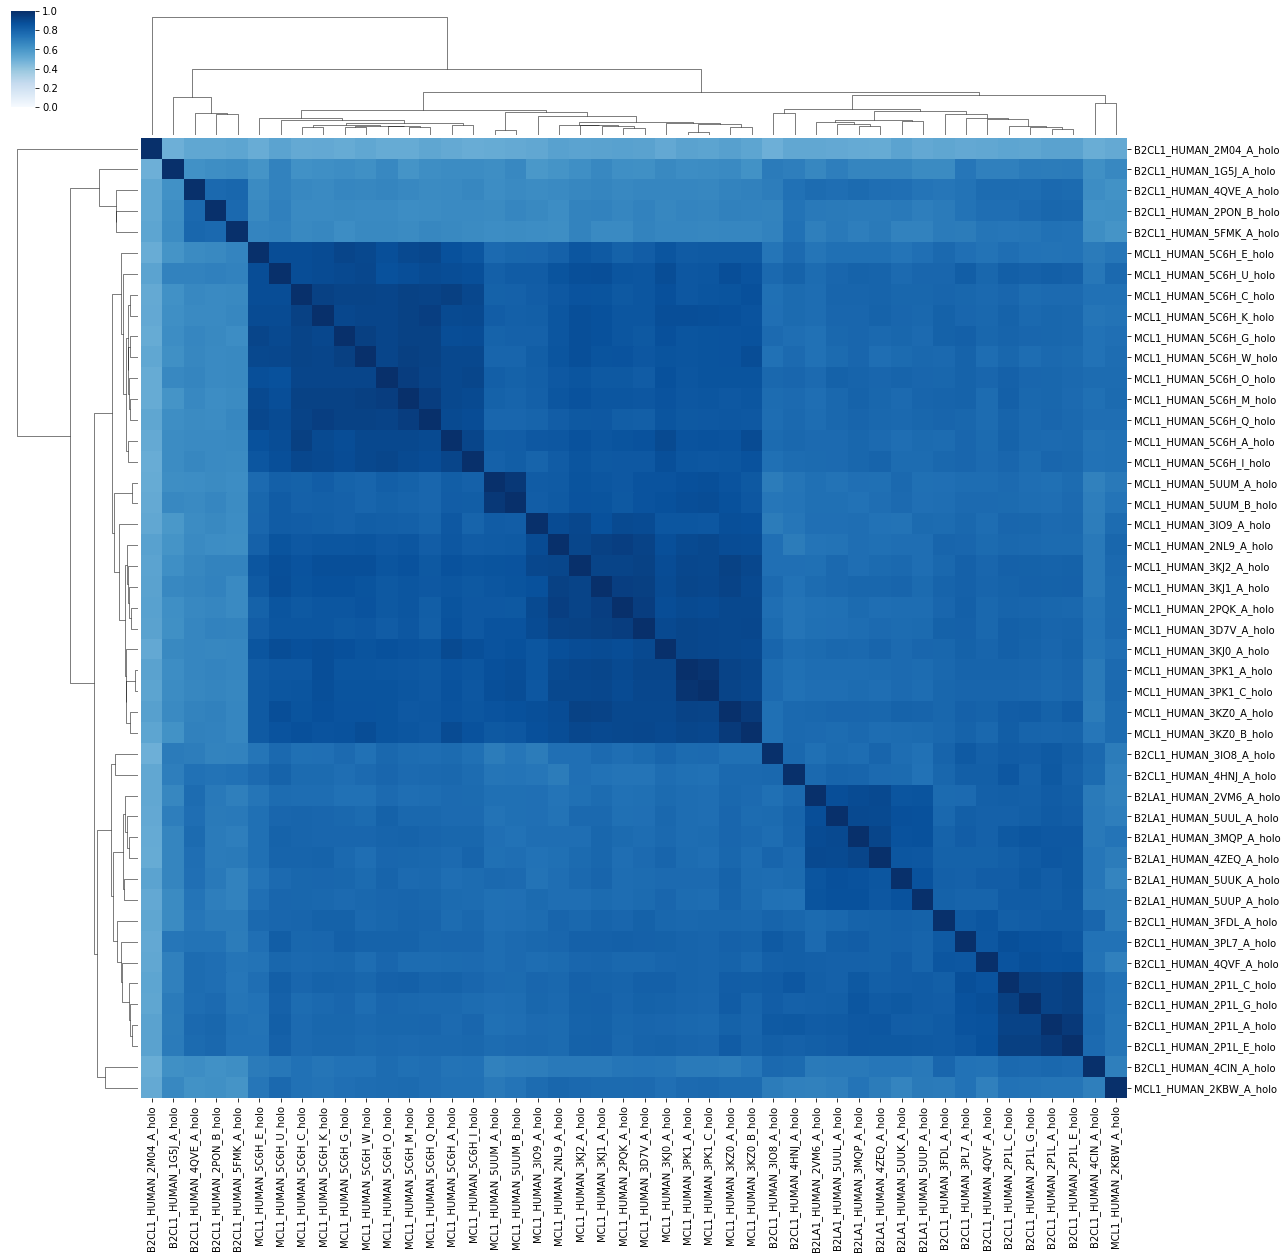

In [10]:

sns.clustermap(pd.DataFrame(Overlap),figsize=(20,20),cmap="Blues",vmin=0)

In [11]:
#Remove binding mode that are "too unique"
#I think they might be bad crystal structrure

ToKeep = OverlapDF.columns
ToRemove = []
for i in range(10):
    tr = OverlapDF[ToKeep].transpose()[ToKeep].mean().sort_values().index[0]
    val = OverlapDF[ToKeep].transpose()[ToKeep].mean().sort_values().values[0]
    ToRemove.append(tr)
    print(tr,val)
    Nkeep = []
    for t in ToKeep:
        if t in ToRemove:continue
        Nkeep.append(t)
    ToKeep = Nkeep

B2CL1_HUMAN_2M04_A_holo 0.541383733674
B2CL1_HUMAN_1G5J_A_holo 0.66456558142
B2CL1_HUMAN_5FMK_A_holo 0.691735819341
B2CL1_HUMAN_2PON_B_holo 0.69811922182
B2CL1_HUMAN_4QVE_A_holo 0.70258728875
B2CL1_HUMAN_4CIN_A_holo 0.743347238891
MCL1_HUMAN_2KBW_A_holo 0.749909415244
B2CL1_HUMAN_3IO8_A_holo 0.777770023123
B2CL1_HUMAN_4HNJ_A_holo 0.780527122267
B2LA1_HUMAN_2VM6_A_holo 0.791343314656


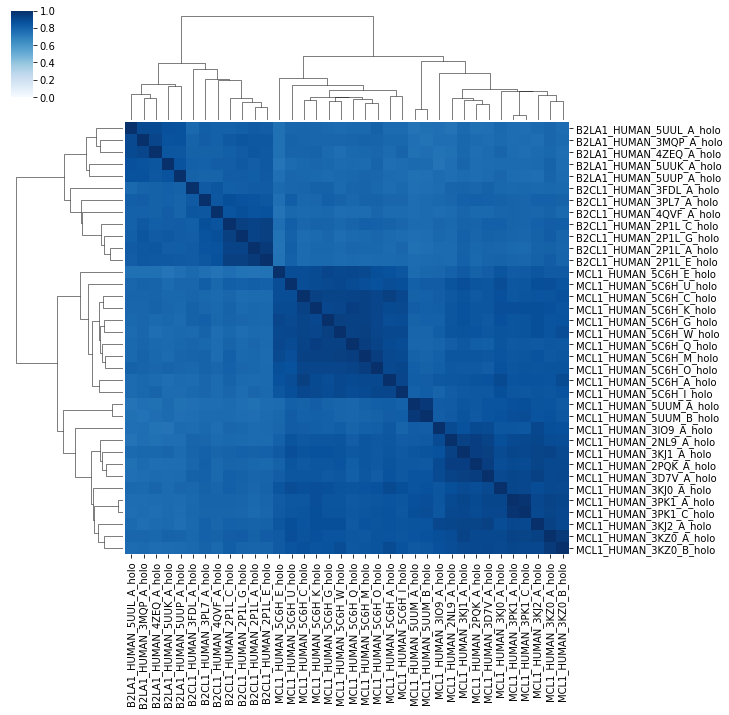

In [12]:
sns.clustermap(OverlapDF[ToKeep].transpose()[ToKeep],cmap="Blues",vmin=0)

In [13]:
PairOccurence = dict()
for pdb1 in ToKeep:
    bs1 = BindingMode[pdb1]
    rec = pdb1.split("_")[0]
    for b in bs1:
        if b not in PairOccurence:PairOccurence[b] = dict()
        if rec not in PairOccurence[b]:PairOccurence[b][rec] = 0
        PairOccurence[b][rec] += 1

In [16]:
#This function return the number of times a contact is found in each recep
def ConserContact(p1,maxp,tr=0.5):
    MinO = []
    for k in maxp:
        #print(k,maxp[k],p1[k])
        if k not in p1:
            MinO.append(0)
            continue
        MinO.append(p1[k]/float(maxp[k]))

    return(MinO)
#ConserContact(PairOccurence[k],MaxPair)

[1.0, 1.0, 1.0]
238 494


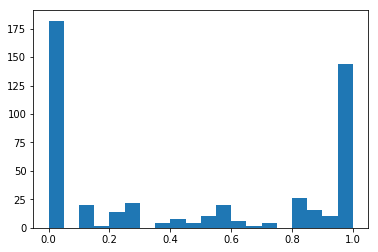

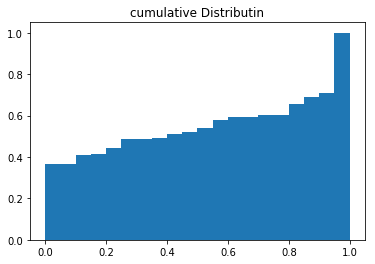

In [20]:
#We want to keep contact that are frequent
MaxPair = PairOccurence["108,B 108,B"]
print(ConserContact(PairOccurence["108,B 108,B"],MaxPair))
KeptPair = []
AllMinOverlap = []

for k in PairOccurence:
    #print(k,PairOccurence[k],ConserContact(PairOccurence[k],MaxPair))
    MinO = ConserContact(PairOccurence[k],MaxPair)
    AllMinOverlap.append(np.min(MinO))
    if np.min(MinO) < 0.5:
        #print(k,PairOccurence[k],ConserContact(PairOccurence[k],MaxPair))
        continue
    KeptPair.append(k)
#    break
print(len(KeptPair),len(PairOccurence))
plt.hist(AllMinOverlap,20)
plt.show()
plt.hist(AllMinOverlap,20,cumulative=1,density=True)
plt.title("cumulative Distributin")
plt.show()

In [21]:
AllScore = dict()
ReceptorContact = dict()
ReceptorContact["All"] = []
AllFeat = []
for k1 in sorted(CountContact):
    sk1 = k1[2:]
    for k2 in sorted(CountContact[k1]):
        sk2 = k2[2:]
        occk = sk1 + " " + sk2
        if occk not in KeptPair:
            continue
        cont_ks = " ".join(sorted([k1,k2]))
        if cont_ks in AllFeat:
            continue
        AllFeat.append(cont_ks)
        for pdbname in AllNormScore:
            if k1 not in AllNormScore[pdbname]:continue
            if k2 not in AllNormScore[pdbname][k1]:continue
            
            
            
            
            if cont_ks not in AllScore:AllScore[cont_ks] = []
            
            AllScore[cont_ks].append(AllNormScore[pdbname][k1][k2])
            recep = pdbname.split("_")[0]
            if recep not in ReceptorContact:
                ReceptorContact[recep] = []
            if ",A" in k2:
                if k2 not in ReceptorContact[recep]:
                    ReceptorContact[recep].append(k2)
                if k2 not in ReceptorContact["All"]:
                    ReceptorContact["All"].append(k2)
                    #print(recep,k2)
            
            


In [26]:
print("I have this many feature=%d" % len(AllFeat))
print("A feature is a contact and a amino acid (Ex:pos 182,A ALA and pos 202B, ARG)")

I have this many feature=18740
A feature is a contact and a amino acid (Ex:pos 182,A ALA and pos 202B, ARG)


In [27]:
#Write everything
pickle.dump(AllScore,open("./data/AllNormScore_small.pk","wb"))
pickle.dump(ReceptorContact,open("./data/ReceptorContact_small.pk","wb"))

   B2LA1 max BS overlap = 14
    MCL1 max BS overlap = 17
   B2CL1 max BS overlap = 15


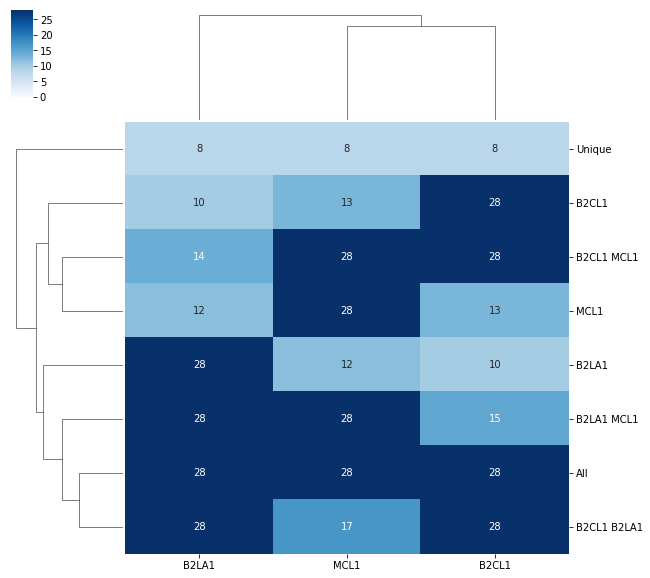

In [42]:
#What is the overlap between each binding site
BindingSiteOver = dict()
Unique = ReceptorContact["All"]
for r1 in ReceptorContact:
    Unique = np.intersect1d(Unique,ReceptorContact[r1])
ReceptorContact["Unique"] = Unique

#Combine
keys = list(ReceptorContact.keys())
for r1 in keys:
    for r2 in keys:
        if r1 == r2:continue
        k = " ".join(sorted([r1,r2]))
        if "All" in k:continue
        if "Unique" in k:continue
        if " " in r1:continue
        if " " in r2:continue
        if k in ReceptorContact:continue
        ReceptorContact[k] = np.unique(ReceptorContact[r1]+ReceptorContact[r2])
OneRecep = ["B2LA1","MCL1","B2CL1"]
for r1 in OneRecep:
    BindingSiteOver[r1] = dict()
    RecepO = []
    for r2 in ReceptorContact:
        bs1 = ReceptorContact[r1]
        bs2 = ReceptorContact[r2]
        #print(r1,r2,len(np.intersect1d(bs1,bs2)),len(bs1),len(bs2))
        BindingSiteOver[r1][r2] = len(np.intersect1d(bs1,bs2))
        if "All" in r1+r2:continue
        if "Unique" in  r1+r2:continue
        if r1 == r2:continue
        if r1 in r2:continue
        if r2 in r1:continue
        RecepO.append(BindingSiteOver[r1][r2])
    print("%8s max BS overlap = %d" % (r1,max(RecepO)))
        #print(r1,r2,BindingSiteOver[r1][r2])
sns.clustermap(pd.DataFrame(BindingSiteOver)[["B2LA1","MCL1","B2CL1"]],cmap="Blues",vmin=0,annot=True)
plt.show()

In [29]:
Unique

array(['D,307,A', 'F,321,A', 'G,313,A', 'N,311,A', 'R,314,A', 'V,300,A',
       'V,316,A', 'W,312,A'],
      dtype='<U7')